# 1. 處理 train data
https://github.com/wshuyi/demo-chinese-text-classification-lstm-keras/blob/master/demo.ipynb

In [1]:
from google.colab import drive
drive.mount("/content/drive")
path =  "/content/drive/Shareddrives/AI_project/"

Mounted at /content/drive


In [2]:
!pip install keras.utils
!pip install jieba
import pandas as pd
import jieba

  Created wheel for keras.utils: filename=keras_utils-1.0.13-cp37-none-any.whl size=2657 sha256=b2580a6be6532830b07d225a9a801745e6523ae2610317e35de4a18cfb201fa4
  Stored in directory: /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be
Successfully built keras.utils


##讀檔

In [3]:
from pathlib import Path
#mypath = Path("demo-chinese-text-classification-lstm-keras")
#-------------Modify the train_path----------------

train_path = path + 'data/train/dianping.csv'

#-----------------------------------
df = pd.read_csv(train_path)
df.head(3)

,comment,sentiment
0,口味：不知道是我口高了，还是这家真不怎么样。 我感觉口味确实很一般很一般。上菜相当快，我敢说...,0
1,菜品丰富质量好，服务也不错！很喜欢！,1
2,说真的，不晓得有人排队的理由，香精香精香精香精，拜拜！,0


## jieba 切字

In [4]:
# Jieba cut the text by " " 
df['text'] = df.comment.apply(lambda x: " ".join(jieba.cut(x))) #"Apply" function of Pandas apply jieba_tokenizer on comment
df = df[['text', 'sentiment']]
#df.head()

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.959 seconds.
Prefix dict has been built successfully.


## keras tokenizer
 1. 在 text裡面找10000個字
 2. 用10000字字典裡 fit_on_all_texts --> word_index
 3. sequences 是轉換成數字的text


In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [6]:
maxlen = 100
max_words = 10000

In [7]:
# Tokenizer turns the text into tokens，and build up a dicictionary of tokens。
# "max_words = 10000" means that we limit our dictionary on 10,000 words，once the max_words has been reached，the remain words will be taken as Unknown.
tokenizer = Tokenizer(num_words=max_words)

# With the dictionary mentioned above,
# we call tokenizer to fit on all the text in df.text(Text Corpus) 並建立一個字典：
tokenizer.fit_on_texts(df.text)

#等到 tokenizer 建好字典以後，我們可以進行上述第 4 個步驟，請 tokenizer 利用內部生成的字典分別將text轉換成數字序列：
sequences = tokenizer.texts_to_sequences(df.text)

In [8]:
# sequences Python list，裡頭包含了每一筆text 對應的數字序列。
type(sequences)
print(len(sequences))
print(sequences[:1])

word_index = tokenizer.word_index
print(word_index)

#------------------實驗------------------
'''
import jieba.posseg as pseg
text = '还是这家真不怎么样'
words = pseg.cut(text)
words = [w for w, f in words]
print(words)
print([word_index[w] for w in words])
# 利用 tokenizer.index_word 來將索引數字對應回本來的詞彙：
for seq in sequences[:1]:
   print([tokenizer.index_word[idx] for idx in seq])
'''

2000
[[51, 193, 12, 75, 7, 4465, 201, 3, 1, 43, 104, 295, 589, 4, 5, 16, 50, 51, 370, 9, 37, 9, 37, 4, 81, 567, 241, 1, 4466, 23, 20, 11, 7, 251, 970, 2, 4, 728, 11, 12, 467, 4, 44, 193, 489, 105, 862, 1, 3151, 3151, 2, 1, 74, 691, 4467, 4, 1798, 1417, 4, 4, 4, 41, 193, 2071, 371, 389, 370, 17, 1, 46, 1178, 255, 1, 1799, 4, 45, 193, 37, 39, 4, 2468, 19, 1, 46, 10, 2469, 4, 127, 193, 37, 1, 211, 127, 1, 11, 128, 590, 4, 25, 193, 905, 3, 1, 48, 9, 1179, 4, 117, 12, 48, 521, 1281, 281, 2072, 468, 18, 863, 269, 1, 48, 14, 405, 3, 4, 4468, 193, 1561, 4469, 6, 3152, 16, 1028, 49, 1029, 207, 24, 1800, 5, 567, 12, 4470, 1, 38, 66, 157, 2470, 538, 4471, 864, 4]]
{'，': 1, '的': 2, '了': 3, '。': 4, '\xa0': 5, '！': 6, '是': 7, '吃': 8, '很': 9, '也': 10, '都': 11, '不': 12, '味道': 13, '就': 14, '还': 15, '我': 16, '不错': 17, '去': 18, '好': 19, '菜': 20, '没有': 21, '好吃': 22, '说': 23, '有': 24, '人': 25, '就是': 26, '点': 27, '服务员': 28, '可以': 29, '和': 30, '没': 31, '…': 32, '我们': 33, '等': 34, '来': 35, '多': 36, '一般': 37, 

"\nimport jieba.posseg as pseg\ntext = '还是这家真不怎么样'\nwords = pseg.cut(text)\nwords = [w for w, f in words]\nprint(words)\nprint([word_index[w] for w in words])\n# 利用 tokenizer.index_word 來將索引數字對應回本來的詞彙：\nfor seq in sequences[:1]:\n   print([tokenizer.index_word[idx] for idx in seq])\n"

## padding



In [9]:
#  不知道在幹嘛，猜測print 5 筆text長度
#for sequence in sequences[:5]:
  #print(len(sequence))

# 使用 Keras函式 pad_sequences ：
data = pad_sequences(sequences, maxlen=maxlen,truncating="post", padding="post")
#print(data[0])

# 改動版本(未完成)

## 用標好的leabel建embedding matrix

In [ ]:
labels = np.array(df.sentiment)

In [ ]:
# 利用 Keras 做 One Hot Encoding：
from keras.utils.np_utils import to_categorical
# 定義每一個分類對應到的索引數字

m_train = np.asarray(labels).astype('float32')

print(m_train[:5])

[0. 1. 0. 1. 1.]


In [ ]:
'''
三個type的mapping
[1, 0, 0] 代表 label 為 unrelated
[0, 1, 0] 代表 label 為 agreed
[0, 0, 1] 代表 label 為 disagreed

m_train = to_categorical(m_train)
print(m_train[:5])
'''

##分割dataset

In [ ]:
from sklearn.model_selection import train_test_split

VALIDATION_RATIO = 0.1
# 小彩蛋
RANDOM_STATE = 9
x1_train = data
x2_train = data
y_train = np.array(df.sentiment)
# Divide
x1_train, x1_val, x2_train, x2_val, y_train, y_val = \
train_test_split( x1_train, x2_train, y_train, 
        test_size=VALIDATION_RATIO, 
        random_state=RANDOM_STATE
)

In [ ]:
print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"x2_train: {x2_train.shape}")
print(f"y_train : {y_train.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"x2_val:   {x2_val.shape}")
print(f"y_val :   {y_val.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (1800, 100)
x2_train: (1800, 100)
y_train : (1800,)
----------
x1_val:   (200, 100)
x2_val:   (200, 100)
y_val :   (200,)
----------
Test Set


In [ ]:
for i, seq in enumerate(x1_train[:2]):
    print(f"新聞標題 {i + 1}: ")
    print([tokenizer.index_word.get(idx, '') for idx in seq])
    print()

新聞標題 1: 
['没什么', '新意', '和', '特色', '。', '有些', '让', '人', '失望', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

新聞標題 2: 
['真', '没', '感觉', '特别', '好', '，', '也许', '是', '吃', '不惯', '巴西', '烤肉', '，', '吃', '了', '一点', '就', '饱', '了', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']



## MODEL

In [ ]:
# 基本參數設置，有幾個分類
NUM_CLASSES = 2

# 在語料庫裡有多少詞彙
MAX_NUM_WORDS = 10000

# 一個標題最長有幾個詞彙
MAX_SEQUENCE_LENGTH = 100

# 一個詞向量的維度
NUM_EMBEDDING_DIM = 256

# LSTM 輸出的向量維度
NUM_LSTM_UNITS = 128

In [ ]:
from keras import Input
from keras.layers import Embedding, \
    LSTM, concatenate, Dense
from keras.models import Model

# 分別定義 2 個新聞標題 A & B 為模型輸入
# 兩個標題都是一個長度為 100 的數字序列
top_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')
bm_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

# 詞嵌入層
# 經過詞嵌入層的轉換，兩個新聞標題都變成
# 一個詞向量的序列，而每個詞向量的維度
# 為 256
embedding_layer = Embedding(
    MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
top_embedded = embedding_layer(
    top_input)
bm_embedded = embedding_layer(
    bm_input)

# LSTM 層
# 兩個新聞標題經過此層後
# 為一個 128 維度向量
shared_lstm = LSTM(NUM_LSTM_UNITS)
top_output = shared_lstm(top_embedded)
bm_output = shared_lstm(bm_embedded)

# 串接層將兩個新聞標題的結果串接單一向量
# 方便跟全連結層相連
merged = concatenate(
    [top_output, bm_output], 
    axis=-1)

# 全連接層搭配 Softmax Activation
# 可以回傳 NUM_CLASSES 個成對標題
# 屬於各類別的可能機率
dense =  Dense(
    units=NUM_CLASSES, 
    activation='softmax')
predictions = dense(merged)

# 我們的模型就是將數字序列的輸入，轉換
# 成 NUM_CLASSES 個分類的機率的所有步驟 / 層的總和
model = Model(
    inputs=[top_input, bm_input], 
    outputs=predictions)

In [ ]:
#(300+1)*2個參數
#Param # 則紀錄了每一層所包含的模型參數（Parameters）。
# 詞嵌入層有最多的參數，因為我們要為 字典裡頭的每個詞彙都建立一個 300 維度的詞向量，因此參數量為 10,000 * 300。
# 這張表另外一個值得注意的地方是所有層的 Output Shape 的第一個維度都是 None。而 None 代表著可以是任意的數字。
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 256)     2560000     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 128)          197120      embedding_3[0][0]          

In [ ]:
# 在 Keras 裡頭，第一個維度代表著樣本數（#Samples），比方說前 9 筆新聞標題 A 的數字序列的 shape 應該要是 （9, 100）：
x1_train[:9].shape

(9, 100)

## Define Loss and train

In [ ]:
# Loss function
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
# 決定一次要放多少成對標題給模型訓練
BATCH_SIZE = 512

# 決定模型要看整個訓練資料集幾遍
NUM_EPOCHS = 10

# 實際訓練模型
history = model.fit(
    # 輸入是兩個長度為 20 的數字序列
    x=[x1_train, x2_train], 
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    # 每個 epoch 完後計算驗證資料集
    # 上的 Loss 以及準確度
    validation_data=(
        [x1_val, x2_val], 
        y_val
    ),
    # 每個 epoch 隨機調整訓練資料集
    # 裡頭的數據以讓訓練過程更穩定
    shuffle=True
)

Epoch 1/10
4/4 [==============================] - 18s 3s/step - loss: 0.7112 - accuracy: 0.5705 - val_loss: 0.6312 - val_accuracy: 0.6650
Epoch 2/10
4/4 [==============================] - 11s 3s/step - loss: 0.5990 - accuracy: 0.7141 - val_loss: 0.5498 - val_accuracy: 0.7850
Epoch 3/10
4/4 [==============================] - 11s 3s/step - loss: 0.4851 - accuracy: 0.8396 - val_loss: 0.4567 - val_accuracy: 0.8150
Epoch 4/10
4/4 [==============================] - 11s 3s/step - loss: 0.3419 - accuracy: 0.8834 - val_loss: 0.4772 - val_accuracy: 0.7600
Epoch 5/10
4/4 [==============================] - 12s 3s/step - loss: 0.3084 - accuracy: 0.9009 - val_loss: 0.3567 - val_accuracy: 0.8400
Epoch 6/10
4/4 [==============================] - 13s 3s/step - loss: 0.1664 - accuracy: 0.9490 - val_loss: 0.5368 - val_accuracy: 0.7350
Epoch 7/10
4/4 [==============================] - 12s 3s/step - loss: 0.2210 - accuracy: 0.9143 - val_loss: 0.3717 - val_accuracy: 0.8100
Epoch 8/10
4/4 [==================

## test

In [ ]:
s1 = "歌手蔡依林今天加场演唱会压轴场，邀歌手周兴哲任嘉宾合唱「怎么了」。蔡依林也邀周兴哲合作，但笑称自己很挑剔，周兴哲笑回：「我会写到妳满意。」', 'Jolin重返台北小巨蛋，耗资新台币400万元翻新6套表演服，希望让观众耳目一新，也特别加码演出和全球百大DJ R3HAB合作新歌Stars Align规划的舞蹈动作。 ', '周兴哲表示，收到邀请时兴奋到想开香槟庆祝，感觉梦想成真，「我一直都觉得（蔡依林）姐走得非常前面」，非常厉害，能达到目前成就很不简单，很钦佩她一直努力、付出心血才成就现在的自己。 ', '周兴哲最喜欢蔡依林的「说爱你」，除欣赏音乐节奏，也很喜欢洗脑旋律；两人合唱「怎么了」、「你怎么连话都说不清楚」，掀起全场尖叫。 ', '蔡依林在舞台上表示，相当欣赏周兴哲才华，希望之后有机会合作，更笑说：「我很挑剔喔！3年才发一张（专辑）。」周兴哲笑回：「我会写到妳满意。」"
s2 = "曾公开批评川普称他总统位置是被偷走的说法。众院共和党领袖麦卡锡（Kevin McCarthy）说，丽兹的批评分散了外界注意力，导致党内向民主党籍总统拜登传达的讯息失焦。', '拜登去年11月总统大选击败川普胜选，今年1月上任。', '麦卡锡告诉福斯新闻（Fox News）：「我们不关切她在弹劾案中如何投票。我们比较关切的是她的工作能力…以及我们最好的下一步是什么，以让我们可以一同合作而非彼此攻讦。」', '美国新闻网站Axios公布录音档报导，受访前，麦卡锡没有注意到麦克风已经开启，说他对丽兹已经「失去信心」。 ', '丽兹发言人发布声明回应麦卡锡的访问时说：「这关乎于共和党是否要让关于2020年选举的谎言持续存在，试图洗刷1月6日发生的事件。丽兹不会这么做。这就是问题所在。」', '外传有数名共和党人可能取代丽兹的位置，包括纽约州联邦众议员斯特凡尼克。斯特凡尼克在川普2019年第一次遭弹劾前，在听证会上替川普辩护，因而逐渐受到瞩目。 "
s3 = "4至17日访问中国上海，并与中国气候变化事务特使解振华举行会谈。此后，中美18日对此发表联合声明，指「两国均期待4月22日到23日美国主办的领导人气候峰会」。 ', '此外，汪文斌针对凯瑞这次访问上海表示，双方会谈期间针对合作因应气候变化、领导人气候峰会、联合国气候变化架构公约、第26次气候会议等议题，进行了「坦诚深入建设性的沟通交流，取得了积极的进展，重启中美气候变化对话合作渠道」。 ', '汪文斌指出，双方强调，气候变化是对人类生存发展严峻而紧迫的威胁。中美两国将加强合作，与其他各方一道共同努力应对气候危机，全面落实「联合国气候变化架构公约」及其「巴黎协定」的原则和规定，为推进全球气候治理做出贡献。 ', '他说，中美双方将继续保持沟通对话，在强化政策措施，推动绿色低碳转型，支持发展中国家能源低碳发展等领域，进一步加强交流与合作。 （编辑：邱国强/吴柏纬）1100419"



my_dic = {"text":[s1,s2,s3]}
my_df = pd.DataFrame(my_dic)
my_df['text'] = my_df.text.apply(lambda x: " ".join(jieba.cut(x)))
my_df.head()

,text
0,歌手 蔡依林 今天 加场 演唱会 压轴 场 ， 邀 歌手 周兴 哲任 嘉宾 合唱 「 怎么 ...
1,曾 公开批评 川普称 他 总统 位置 是 被 偷走 的 说法 。 众院 共和党 领袖 麦卡锡...
2,4 至 17 日 访问 中国 上海 ， 并 与 中国 气候变化 事务 特使 解振华 举行会谈...


In [ ]:
'''tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(my_df.text)
sequences = tokenizer.texts_to_sequences(my_df.text)
data = pad_sequences(sequences, maxlen=maxlen)
'''
def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([
        word for word, flag in words if flag != 'x'])
    
test= my_df
test['title1_tokenized'] = test.loc[:, 'text'].apply(jieba_tokenizer)
print(test)
x1_test = tokenizer.texts_to_sequences(test.title1_tokenized)

x1_test = pad_sequences(x1_test,maxlen=MAX_SEQUENCE_LENGTH)
predictions = model.predict([x1_test, x1_test]) #有x2_test就放x2_test
print(predictions[:3])

                                                text                                   title1_tokenized
0  歌手 蔡依林 今天 加场 演唱会 压轴 场 ， 邀 歌手 周兴 哲任 嘉宾 合唱 「 怎么 ...  歌手 蔡依林 今天 加场 演唱会 压轴 场 邀 歌手 周兴 哲任 嘉宾 合唱 怎么 了 蔡依...
1  曾 公开批评 川普称 他 总统 位置 是 被 偷走 的 说法 。 众院 共和党 领袖 麦卡锡...  曾 公开批评 川普 称 他 总统 位置 是 被 偷走 的 说法 众院 共和党 领袖 麦卡锡 ...
2  4 至 17 日 访问 中国 上海 ， 并 与 中国 气候变化 事务 特使 解振华 举行会谈...  至 17 日 访问 中国 上海 并 与 中国 气候变化 事务 特使 解振华 举行会谈 此后 ...
[[0.9882637  0.01173631]
 [0.9225146  0.07748535]
 [0.52460206 0.475398  ]]


#2. LSTM Model

## @分割dataset

In [10]:
labels = np.array(df.sentiment)
#MAX_SEQUENCE_LENGTH = 20
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
labels

array([0, 1, 0, ..., 1, 1, 0])

In [11]:
# training_samples : validation_samples = 1600 : 400 = 8 : 2
training_samples = int(len(indices) * .8)
validation_samples = len(indices) - training_samples


In [12]:

X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]

## 用zh_model 做embedded matrix

In [13]:
!pip install gensim

In [14]:
from gensim.models import KeyedVectors

In [15]:
!git clone https://github.com/wshuyi/demo-chinese-text-classification-lstm-keras.git
mypath = Path("demo-chinese-text-classification-lstm-keras")
myzip = mypath / 'zh.zip'
!unzip $myzip

Cloning into 'demo-chinese-text-classification-lstm-keras'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
Archive:  demo-chinese-text-classification-lstm-keras/zh.zip
  inflating: zh.vec                  


In [16]:
zh_model = KeyedVectors.load_word2vec_format('zh.vec')
#zh_model.vectors[0]

In [17]:
list(iter(zh_model.vocab))[:5]
#zh_model.get_vector('的')

['的', '</s>', '在', '是', '年']

In [18]:
len(zh_model[next(iter(zh_model.vocab))])

300

In [19]:
# Word Embedding : 將一個詞彙或句子轉換成一個實數詞向量（Vectors of real numbers）
embedding_dim = len(zh_model[next(iter(zh_model.vocab))])
#embedding_dim

300

In [20]:
# MAX_NUM_WORDS : 字典大小（10,000 個詞彙)
# NUM_EMBEDDING_DIM 詞向量的維度。常見的詞向量維度有 128、256 或甚至 1,024。
# 所以序列裡頭的每個數字（即詞彙）都被轉換成一個 300 維的詞向量
# (相同數字會對應到同一個詞向量（如padding的0 對應相同向量))
embedding_matrix = np.random.rand(max_words, embedding_dim)

In [ ]:
embedding_matrix

In [22]:
embedding_matrix = (embedding_matrix - 0.5) * 2
#embedding_matrix

## 把 word_index 對應到 embedding matrix

In [23]:
# 利用zh_model把每個 word_index.item() 轉換成300維度向量
# 存到embedding_matrix
'''
NTUSD_df = pd.read_csv(path+"data/1_column_title/ntusd.txt", delimiter = "\t")
NTUSD_df.columns=["word"]
words = [w for w in NTUSD_df['word']]
word_index = {
    word: idx  
    for idx, word in enumerate(words)
}
'''

for word, i in word_index.items():
    if i < max_words:
        try:
          embedding_vector = zh_model.get_vector(word)
          embedding_matrix[i] = embedding_vector
        except:
          pass
print(len(embedding_matrix))


10000


## train

In [24]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, GRU
from keras.optimizers import Adam

units = 16

model = Sequential()
model.add(Embedding(max_words, embedding_dim))
model.add(LSTM(units))
#model.add(LSTM(2))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                20288     
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 3,020,305
Trainable params: 3,020,305
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [26]:
# 定義模型的損失函數：
'''
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
'''
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=4,
                    batch_size=16,
                    validation_data=(X_valid, y_valid))
model.save("mymodel.h5")

Epoch 1/4
100/100 [==============================] - 20s 31ms/step - loss: 0.7075 - acc: 0.5012 - val_loss: 0.6815 - val_acc: 0.5375
Epoch 2/4
100/100 [==============================] - 2s 24ms/step - loss: 0.6870 - acc: 0.5229 - val_loss: 0.6781 - val_acc: 0.5425
Epoch 3/4
100/100 [==============================] - 2s 24ms/step - loss: 0.6727 - acc: 0.5373 - val_loss: 0.6717 - val_acc: 0.5475
Epoch 4/4
100/100 [==============================] - 2s 24ms/step - loss: 0.6580 - acc: 0.5589 - val_loss: 0.6738 - val_acc: 0.5475


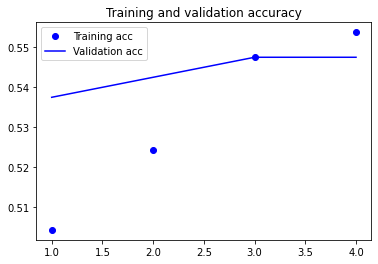

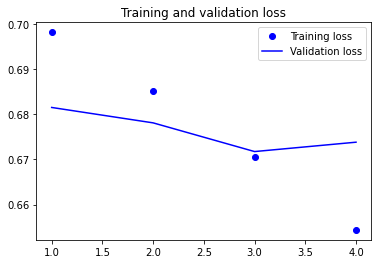

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# test

In [28]:

my_df = pd.read_csv(path + 'data/1_column_title/simple_label_2kind.csv')
test_title = my_df['title']
test_label = my_df['label']

my_df['title'] = my_df.title.apply(lambda x: " ".join(jieba.cut(x)))
#my_df.head()


,Unnamed: 0,title,label
0,0,美 捐赠 疫苗 250 万剂 江启臣 ： 印证 台美 情谊,1
1,1,灭绝 40 年 巨獭 现身 了 ！ 保育员 吓坏 录影 ： 没人会 相信 我,1
2,2,大陆 经济 持续 复 甦 好转 中 陆股 后市 看俏,1
3,3,不 只 郭董 、 刘德音 ！ 蔡 英文 曝 政府 也 要 买 BNT 疫苗,1
4,4,疫情 期间 穷到 断炊 ？ 炒 饭店 老板 霸气 助人 ： 拢 来 我 请,1


In [29]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(my_df.title)
sequences = tokenizer.texts_to_sequences(my_df.title)
data = pad_sequences(sequences, maxlen=maxlen)

X_test= data
predictions = model.predict(X_test)
correct_cnt = 0.0
for i in range (len(predictions)):
  label = 0 if predictions[i] < 0.5 else 1
  if label != test_label[i]:
    None
    #print(test_title[i], test_label[i]," wrong predict : ", label)
  else :
    correct_cnt += 1
print("正確率 : ", 100*correct_cnt/len(predictions),"%")


正確率 :  63.06306306306306 %


#利用原始Model_output

In [ ]:
!pip install snownlp
from snownlp import SnowNLP

     |████████████████████████████████| 37.6MB 72kB/s 
  Created wheel for snownlp: filename=snownlp-0.12.3-cp37-none-any.whl size=37760967 sha256=9f2c1f9d0d8d214a31b2f41968b5811633f8491f9f522543a7c38e06365f2924
  Stored in directory: /root/.cache/pip/wheels/f3/81/25/7c197493bd7daf177016f1a951c5c3a53b1c7e9339fd11ec8f
Successfully built snownlp


In [ ]:
path =  "/content/drive/Shareddrives/AI_project/"
df = pd.read_csv(path + 'data/news_all.csv')
df_3col = df[['media', 'category', 'content']]
sector = df_3col.groupby('media')
#----------------------------------------------------------------
for media in ["中時","中央社", "三立"]:
  m = sector.get_group(media) #m=media
  mc = m.groupby('category') #mc=media category
  mc_P = mc.get_group('政治')['content'] # mc_P's P means politic
  data_array = []
  for line in mc_P : 
    simple = SnowNLP(line).han #轉簡體
    data_array.append(simple)
  data = pd.DataFrame(data_array, columns = ['text'])
  data['text'] = data.text.apply(lambda x: " ".join(jieba.cut(x)))
  #----------------------------------------------------------------
  tokenizer = Tokenizer(num_words=max_words)
  tokenizer.fit_on_texts(data.text)
  sequences = tokenizer.texts_to_sequences(data.text)
  type(sequences)
  data_cnt = (len(sequences))
  print("data_cnt : ",data_cnt)
  #----------------------------------------------------------------
  data = pad_sequences(sequences, maxlen=maxlen)
  #----------------------------------------------------------------
  pos_idx = []
  nu_idx  = []
  neg_idx  = [] 
  pos_cnt = 0
  nu_cnt = 0
  neg_cnt = 0

  for i in range(data_cnt):
    prediction = model.predict(data[i:i+1])
    predict_value = (prediction[0][0])
    if (predict_value)<0.3 : 
      neg_cnt+=1
      neg_idx.append(i)
    else:
      if predict_value>0.6:
        pos_cnt+=1
        pos_idx .append(i)
      else :
        nu_cnt+=1
        nu_idx .append(i)
  #----------------------------------------------------------------
  path =  "/content/drive/Shareddrives/AI_project/"
  filepath = path+'result/'+ media +'/'+"Demo_"
  print(pos_cnt, nu_cnt, neg_cnt)

  path = filepath+'.txt'
  f = open(path, 'w')
  f.write(str(pos_cnt)+" ")
  f.close()
  f = open(path, 'a')
  f.write(str(nu_cnt)+" ")
  f.write(str(neg_cnt))
  f.close()
  #----------------------------------------------------------------
  pos = []
  nu = []
  neg = [] 
  for idx in pos_idx : pos.append(data_array[idx])
  for idx in nu_idx : nu.append(data_array[idx])
  for idx in neg_idx : neg.append(data_array[idx])

  p = pd.DataFrame(pos)
  p.to_csv(filepath+"pos.csv")

  nu = pd.DataFrame(nu)
  nu.to_csv(filepath+"nu.csv")

  neg = pd.DataFrame(neg)
  neg.to_csv(filepath+"neg.csv")

data_cnt :  11928
3602 5666 2660
data_cnt :  3702
746 1890 1066
data_cnt :  1910
294 608 1008


In [ ]:
print(p[0])

0      ['记者林瑞恩／综合报导', '疫苗话题炒翻天，国民党多名委员、网军，频频攻击放宽采购国产疫...
1      ['记者卢素梅／台北报导', '兴达电厂今（13）日下午出现全厂停机，国内出现大规模停电，对...
2      ['记者李鸿典／台北报导', '本土疫情未歇，行政院今（7）天宣布全国三级警戒延长两周，至6...
3      ['记者陈政宇／台北报导', '中国大陆国台办发言人朱凤莲今（12）日点名我国部长吴钊燮是「...
4      ['记者卢素梅／台北报导', '本土疫情持续升温，但中央疫情指挥中心今（25）日宣布台北市有...
                             ...                        
289    ['记者卢素梅／台北报导', '国内本土案例爆发，已经进入社区感染，即日起至6月8日提升疫情...
290    ['政治中心／综合报导', '中央流行疫情指挥中心今（18）日公布国内有240例本土，包含新...
291    ['政治中心／综合报导', '行政院长苏贞昌今（8日）赴立法院报告纾困预算案及疫苗采购及施打...
292    ['记者陈政宇／台北报导', '印度疫情严峻，连日来确诊与病故人数都屡创新高，我国驻处目前共...
293    ['民进党立委苏巧慧等人提案修公投法，增订连署人名册应亲自签名、附身分证影本等规定。国民党立...
Name: 0, Length: 294, dtype: object
